## Import Library

Pada Tahap pertama ini import seluruh library yang dibutuhkan.

In [1]:
# Import library

!pip install keras
from google.colab import drive
import zipfile
import os
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from collections import Counter
from sklearn.metrics.pairwise import linear_kernel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

## Load data

Tahap selanjutnya load data yang diperlukan, disini data diambil dari google drive dalam bentuk zip, dan dilakukan unzip data untuk diekstraksi.

In [2]:
# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path ke file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/dataset_movie.zip'

# 3. Lokasi untuk mengekstrak isi ZIP
extract_path = '/content/dataset_movie'

# 4. Ekstraksi file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 5. Cek hasil ekstraksi
print("Isi folder setelah ekstraksi:")
print(os.listdir(extract_path))


Mounted at /content/drive
Isi folder setelah ekstraksi:
['__MACOSX', 'dataset_movie']


Pada tahap ini dataset  disimpan ke dataframe dengan nama df_movie dan df_rating.

In [3]:
# Load dataset ke dataframe df_movie & df_rating
df_movie = pd.read_csv('dataset_movie/dataset_movie/movies.csv')
df_rating = pd.read_csv('dataset_movie/dataset_movie/ratings.csv')

## Data Understanding & EDA

Selanjutkan menampilkan data sample dari df_movie. Dan didapatkan bahwa di data df_movie memiliki kolom movieId, title dan genres.

In [4]:
# Cek sample data df_movie
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


Selanjutnya menampilkan deskripsi detail dari df_movie.

In [5]:
# Cek describe data df_movie

df_movie.describe()


,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


Menampilkan deskripsi df_rating, dari nilai minimum, std hingga total data.

In [6]:
# Cek describe data df_ratings

df_rating.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


insight= rating terkecil ada di rating 0,5 dan tertinggi di rating 5.

Menampilkan sample data dari df_rating. Didapatkan di data df_rating memiliki kolom userId, movieId, rating dan timestamp.

In [7]:
# Cek sample data df_rating
df_rating

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


Pada tahap ini cek informasi detail dari dataframe df_movie & df_rating.

In [8]:
# Cek informasi dari dataset
print(df_movie.info())
print()
print(df_rating.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
None


Insight= pada df_movie didapatkan movieId memiliki tipe data integer, title & genres memiliki tipe data string.

pada df_rating= userId, movieId, dan time stamp memiliki tipe data integer, dan rating memiliki tipe data float.

Pada tahap ini cek data null.

In [9]:
# Cek data null
print(df_movie.isnull().sum())
print(df_rating.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Insight= Setelah pengecekan tidak didapatkan data null di kedua dataframe.

Pada tahap ini dilakukan cek data duplikat.

In [10]:
# Cek data duplikat
print(df_movie.duplicated().sum())
print(df_rating.duplicated().sum())

0
0


In [ ]:
Insight= Setelah pengecekan tidak ada data duplikat di kedua dataframe.

Pada tahap ini cek total data unik users & movie.

In [11]:
# Cek total unique users dan movies
print("Unique users:", df_rating['userId'].nunique())
print("Unique movies:", df_rating['movieId'].nunique())



Unique users: 162541
Unique movies: 59047


Insight= Didapatkan sebanyak 162541 unique users dan 59047 unique movies dari df_rating.

### Distribusi data

Pada tahap ini dilakukan visualisasi untuk distribusi data rating.

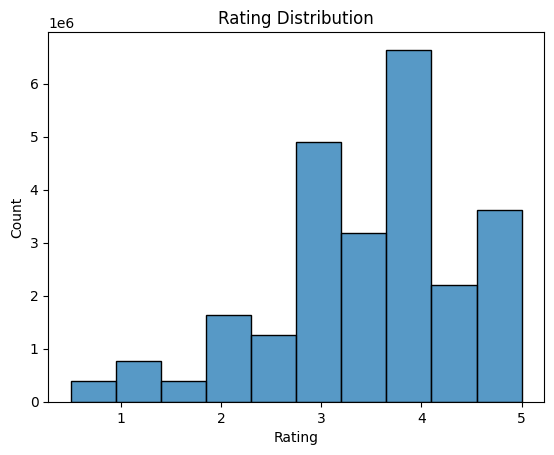

In [12]:
# Distribusi data rating
sns.histplot(df_rating['rating'], bins=10, kde=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Insight= data rating ada di jangkauan 0,5 hingga 5. Dengan total rating paling banyak ada di angka rating 4.

Selanjutnya visualisasi top 10 movie dengan rating terbanyak.

<ipython-input-13-c6bbe8951508>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_count', y='title', data=top_movies, palette='viridis')


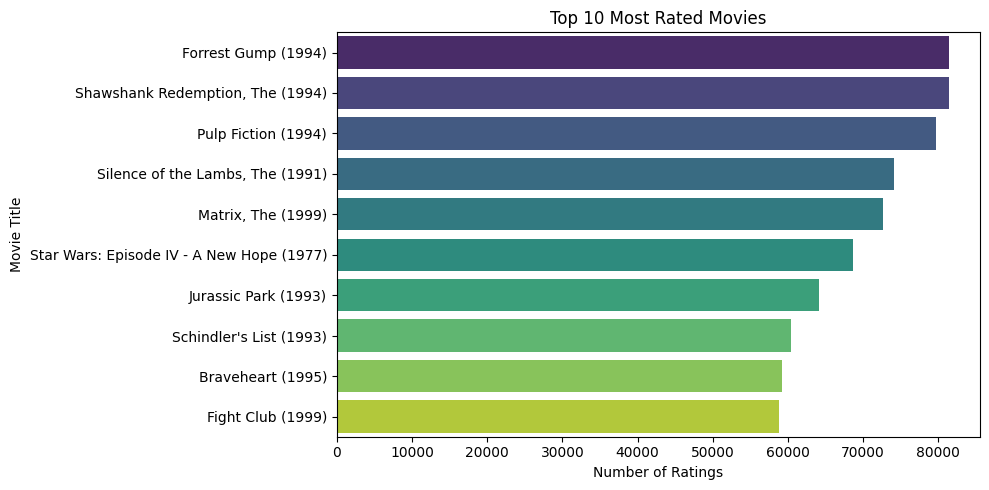

In [13]:
# Top 10 movies dengan rating terbanyak
rating_counts = df_rating.groupby('movieId')['rating'].count().reset_index()
rating_counts.columns = ['movieId', 'rating_count']

top_rated_movies = rating_counts.sort_values('rating_count', ascending=False).head(10)
top_movies = top_rated_movies.merge(df_movie, on='movieId')

plt.figure(figsize=(10,5))
sns.barplot(x='rating_count', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()


berikut merupakan visualisasi top 10 movies yang paling banyak di rate.

Insight= movie dengan total rating terbanyak adalah Forrest Gump dan movie degan total rating paling sedikit adalah Fight Club.

Selanjutnya visualiasi genre paling populer.

<ipython-input-14-2bd7de0a4ab8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=df_genres.head(10), palette='magma')


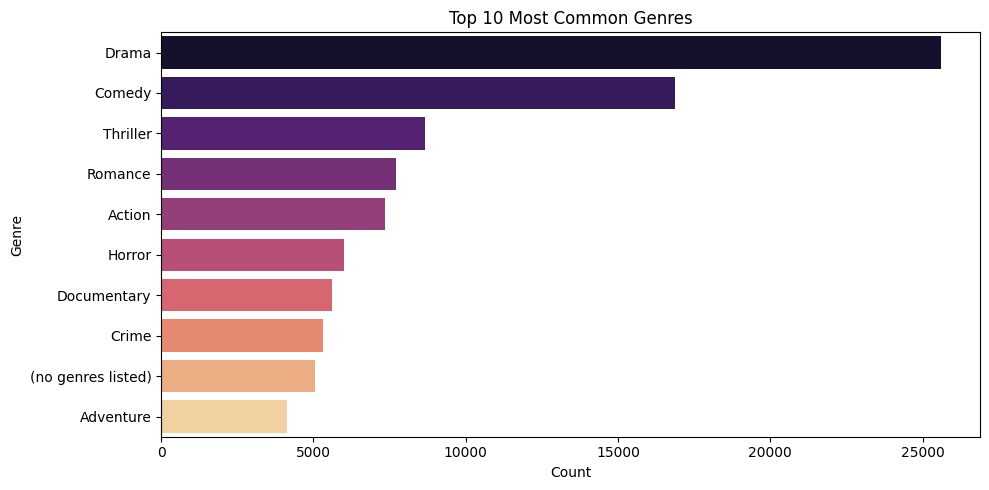

In [14]:
# Distribusi genre populer
df_movie['genres_split'] = df_movie['genres'].str.split('|')

genre_counts = Counter()
df_movie['genres_split'].apply(lambda x: genre_counts.update(x))

# Convert ke DataFrame
df_genres = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='genre', data=df_genres.head(10), palette='magma')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()



Berikut merupakan top 10 genre terpopuler pada dataframe df_movie.

Insight= Genre paling populer adalah Drama dan genre paling tidak populer adalah adventure.

## Data Preparation

### Content based filtering

Pada tahap ini, dilakukan pembuatan subsample dengan variable baru df_movie_sample untuk mengambil 20.000 data sebagai sample dikarenakan terbatasnya RAM dalam pemrosesan data. Selanjutnya dilakukan preprocessing genre, untuk memisahkan genre pada kolom genre. Lalu dilakukan TF-IDF untuk mengubah data genre yang sudah dipisah menjadi representasi numerik.

In [15]:
# 1. Subset sample 20000 film (karena keterbatasan RAM dalam megelola dataset agar model dapat dijalankan)
df_movie_sample = df_movie.sample(n=20000, random_state=42).reset_index(drop=True)

# 2. Preprocessing genre
df_movie_sample['genres'] = df_movie_sample['genres'].str.replace('|', ' ')

# 3. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_movie_sample['genres'])

# 4. Build reverse index
indices = pd.Series(df_movie_sample.index, index=df_movie_sample['title']).drop_duplicates()


Pada tahap ini menampilkan isi dari df_movie_sample

In [16]:
# Menampilkan Subset sample, df_movie_sample
df_movie_sample

,movieId,title,genres,genres_split
0,4990,Jimmy Neutron: Boy Genius (2001),Adventure Animation Children Comedy,"[Adventure, Animation, Children, Comedy]"
1,116698,Dead Men Tell (1941),Comedy Crime Drama Mystery Thriller,"[Comedy, Crime, Drama, Mystery, Thriller]"
2,125517,The D.I. (1957),Drama,[Drama]
3,196541,Makar - Pathfinder (1984),Adventure Children,"[Adventure, Children]"
4,156511,Feudin' Fools (1952),Comedy,[Comedy]
...,...,...,...,...
19995,145885,Les quatre vérités (1962),(no genres listed),[(no genres listed)]
19996,7316,Confessions of a Teenage Drama Queen (2004),Comedy,[Comedy]
19997,189863,The Silent Revolution (2018),Drama,[Drama]
19998,106620,Z.P.G. (1972),Sci-Fi Thriller,"[Sci-Fi, Thriller]"


Insight= didapatkan 4 kolom yaitu movieId, title, genres dan genre_split dengan 20.000 data.

### Colaborative Filtering

Pada tahap ini membuat dataframe baru yaitu df_rating_sample untuk mengambil 20.000 data dari dataframe utama.

<Axes: >

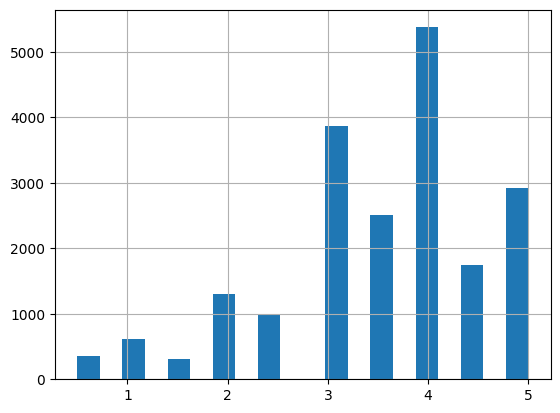

In [17]:
# Subset sample 20000 rating film (karena keterbatasan RAM dalam megelola dataset agar model dapat dijalankan)
df_rating_sample = df_rating.sample(n=20000, random_state=42).copy()

# cek distribusi rating
df_rating_sample['rating'].hist(bins=20)

Membuat data sample sebesar 20.000 data menjadi df_rating_sample.

Insight= mengambil data sample sebesar 20.000 data, walaupun mengambil sebagian kecil dari data, namun distribusi data rating tidak berubah signifikan, yaitu data rating 4 masih menjadi rating paling banyak dari user.

Pada tahap berikutnya, Kode ini digunakan untuk melakukan encoding terhadap userId dan movieId dalam dataframe df_rating_sample, agar dapat digunakan dalam model machine learning, khususnya sistem rekomendasi. Pertama, kode mengambil daftar unik userId dan movieId, lalu membuat mapping dari ID asli ke indeks numerik menggunakan enumerate, sehingga tiap pengguna dan film diberi representasi angka yang unik. Mapping sebaliknya juga dibuat untuk keperluan decoding hasil model nantinya. Setelah itu, kolom baru user dan movie ditambahkan ke dataframe dengan hasil mapping tersebut. Terakhir, kode menghitung jumlah total user, jumlah film, serta nilai rating minimum dan maksimum sebagai informasi tambahan yang bisa digunakan dalam pemodelan.

In [18]:
# Mendapatkan list unik userId dan movieId
user_ids = df_rating_sample['userId'].unique().tolist()
movie_ids = df_rating_sample['movieId'].unique().tolist()

# Mapping user dan movie ke index
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
userencoded2user = {i: x for x, i in user2user_encoded.items()}
movieencoded2movie = {i: x for x, i in movie2movie_encoded.items()}

# Tambahkan kolom hasil encoding ke dataframe
df_rating_sample['user'] = df_rating_sample['userId'].map(user2user_encoded)
df_rating_sample['movie'] = df_rating_sample['movieId'].map(movie2movie_encoded)

# Jumlah user dan film
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
min_rating = df_rating_sample['rating'].min()
max_rating = df_rating_sample['rating'].max()


Selanjutnya pada tahap ini, kode ini mempersiapkan data untuk proses pelatihan model dengan mengambil fitur input berupa pasangan user dan movie dalam bentuk array x, serta nilai rating sebagai target y yang dikonversi ke tipe float32 untuk kompatibilitas dengan model machine learning. Selanjutnya, data dibagi menjadi data latih (x_train, y_train) dan data validasi (x_val, y_val) menggunakan fungsi train_test_split dari scikit-learn, dengan proporsi 80% untuk pelatihan dan 20% untuk validasi, serta random_state=42 digunakan untuk memastikan pembagian data yang konsisten (reproducible) setiap kali kode dijalankan.

In [19]:
x = df_rating_sample[['user', 'movie']].values
y = df_rating_sample['rating'].values.astype(np.float32)

# Train/Test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Modelling

### Content based filtering

Pada tahap ini, Kode digunakan untuk membuat sistem rekomendasi film berbasis konten menggunakan pendekatan cosine similarity. Pertama, dihitung kemiripan antar film menggunakan linear_kernel pada matriks TF-IDF (tfidf_matrix), yang merepresentasikan fitur teks dari deskripsi atau informasi film. Kemudian, fungsi get_recommendations_content menerima input berupa judul film dan akan mencari film lain yang paling mirip berdasarkan nilai cosine similarity. Fungsi ini bekerja dengan mengambil indeks film berdasarkan judul, lalu menghitung dan mengurutkan skor kemiripannya terhadap semua film lain, dan mengambil top_n film paling mirip (selain film itu sendiri). Hasil akhirnya adalah daftar judul film yang direkomendasikan berdasarkan kemiripan konten.

In [20]:
# Hitung cosine similarity antar film
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Fungsi rekomendasi berdasarkan title
def get_recommendations_content(title, top_n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return df_movie_sample['title'].iloc[movie_indices].tolist()


Pada tahap ini, Kode digunakan untuk menguji fungsi rekomendasi berbasis konten (get_recommendations_content) dengan memasukkan judul film "The Silent Revolution (2018)" sebagai input. Fungsi ini akan mengembalikan daftar film yang memiliki kemiripan konten tertinggi dengan film ini. Hasil rekomendasi kemudian dicetak ke layar dengan format yang terurut, menampilkan urutan dan judul dari film-film yang direkomendasikan. Tujuannya adalah untuk melihat apakah sistem rekomendasi dapat memberikan saran film yang relevan berdasarkan kemiripan isi.

In [21]:
# Tes fungsi rekomendasi content based filtering
movie_title = 'The Silent Revolution (2018)'
recommendations_content = get_recommendations_content(movie_title)
print(f"Rekomendasi untuk '{movie_title}':")
for i, rec in enumerate(recommendations_content):
    print(f"{i+1}. {rec}")

Rekomendasi untuk 'The Silent Revolution (2018)':
1. Tony Takitani (2004)
2. Hunger (2001)
3. Yugotrip (2004)
4. Afterimage (2017)
5. Mourning for Anna (2010)
6. The Tobacconist (2018)
7. Snowland (2005)
8. The Song of Sway Lake (2017)
9. Sexual Dependency (Dependencia sexual) (2003)
10. Arrhythmia (2017)


Insight= berdasarkan hasil rekomendasi dari content based filtering, dari judul film The Silent Revolution (2018), didapatkan 10 film rekomendasi yang relevan, yaitu 1. Tony Takitani (2004)
2. Hunger (2001)
3. Yugotrip (2004)
4. Afterimage (2017)
5. Mourning for Anna (2010)
6. The Tobacconist (2018)
7. Snowland (2005)
8. The Song of Sway Lake (2017)
9. Sexual Dependency (Dependencia sexual) (2003)
10. Arrhythmia (2017)

### Collaborative Filtering

#### RecommenderNet

Pada tahap ini, Saya mendefinisikan sebuah model rekomendasi berbasis pembelajaran mendalam menggunakan arsitektur RecommenderNet, yang merupakan subclass dari Model di TensorFlow. Model ini menggunakan pendekatan embedding untuk merepresentasikan pengguna dan film ke dalam vektor berdimensi tetap (embedding_size). Dalam metode __init__, dua layer embedding dibuat masing-masing untuk user dan movie, lalu dikombinasikan menggunakan operasi dot product untuk mengukur interaksi di antara keduanya. Hasil dot product kemudian diproses oleh layer Dense dengan aktivasi sigmoid dan diskalakan ke rentang rating sebenarnya, yaitu antara min_rating dan max_rating. Fungsi call menerima input pasangan user dan movie dalam bentuk ID numerik, mengambil representasi vektornya, menghitung kesamaan melalui dot product, dan mengembalikan prediksi rating yang telah diskalakan ke rentang yang sesuai. Model ini cocok digunakan untuk membangun sistem rekomendasi berbasis interaksi antara user dan item.



In [22]:
# Model rekomendasi berbasis pembelajaran mendalam menggunakan embedding dan dot product
class RecommenderNet(Model):
    def __init__(self, num_users, num_movies, embedding_size=50, min_rating=0.5, max_rating=5.0):
        super().__init__()
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal')
        self.movie_embedding = layers.Embedding(num_movies, embedding_size, embeddings_initializer='he_normal')
        self.dot = layers.Dot(axes=1)
        self.output_dense = layers.Dense(1, activation='sigmoid')
        self.min_rating = min_rating
        self.max_rating = max_rating

    # Fungsi pemanggilan model
    # Menerima input pasangan user dan movie (dalam bentuk ID), dan menghasilkan prediksi rating
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        dot_product = self.dot([user_vector, movie_vector])
        scaled_output = self.output_dense(dot_product) * (self.max_rating - self.min_rating) + self.min_rating
        return scaled_output


Pada tahap ini dilakukan inisialisasi, kompilasi, dan pelatihan model rekomendasi RecommenderNet yang telah didefinisikan sebelumnya. Pertama, objek model dibuat dengan memberikan jumlah total user dan movie, serta batas minimum dan maksimum rating. Model kemudian dikompilasi menggunakan fungsi loss mean squared error (mse) karena tugasnya adalah regresi (memprediksi nilai rating), dan menggunakan optimizer Adam dengan learning rate sebesar 0.001. Setelah itu, model dilatih menggunakan data latih (x_train, y_train) dan divalidasi dengan data validasi (x_val, y_val) selama 10 epoch dengan ukuran batch 64. Parameter verbose=1 memastikan bahwa proses pelatihan akan menampilkan output kemajuan pelatihan di konsol.

In [23]:
# Inisialisasi model RecommenderNet
model_recommendernet = RecommenderNet(num_users, num_movies, min_rating=min_rating, max_rating=max_rating)

# Kompilasi model
model_recommendernet.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001)
)

# Melatih model
history_rnet = model_recommendernet.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=10,
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.6976 - val_loss: 1.4119
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3666 - val_loss: 1.2555
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0800 - val_loss: 1.1997
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6550 - val_loss: 1.1955
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2967 - val_loss: 1.2027
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1371 - val_loss: 1.2056
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0704 - val_loss: 1.2106
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0423 - val_loss: 1.2076
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0329 - val_loss: 1.2096
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0268 - val_loss: 1.2071


#### NCF

Pada tahap ini saya mendefinisikan model rekomendasi Neural Collaborative Filtering (NCF) dengan pendekatan pembelajaran mendalam menggunakan subclass Model dari TensorFlow. Model ini memanfaatkan layer embedding untuk mengubah ID pengguna dan film menjadi representasi vektor berdimensi tetap (embedding_size). Vektor pengguna dan film kemudian digabungkan menggunakan Concatenate, lalu diproses melalui dua lapis fully connected layer (Dense) dengan aktivasi ReLU. Untuk mencegah overfitting, disisipkan dua layer Dropout setelah masing-masing Dense layer. Output dari jaringan dilewatkan ke layer Dense dengan aktivasi sigmoid, kemudian diskalakan ke rentang nilai rating sebenarnya (min_rating hingga max_rating). Fungsi call menerima input berupa pasangan ID pengguna dan film, lalu mengembalikannya sebagai prediksi rating. Model NCF ini menggabungkan kekuatan embedding dan jaringan saraf untuk mempelajari interaksi kompleks antara pengguna dan item.

In [24]:
class NCF(Model):
    def __init__(self, num_users, num_movies, min_rating=0.5, max_rating=5.0, embedding_size=50):
        super().__init__()

        # Membuat layer embedding untuk user
        self.user_embedding = layers.Embedding(num_users, embedding_size)

        # Membuat layer embedding untuk movie
        self.movie_embedding = layers.Embedding(num_movies, embedding_size)

        # Menggabungkan vektor user dan movie
        self.concat = layers.Concatenate()

        # Fully connected layer pertama
        self.dense1 = layers.Dense(128, activation='relu')

        # Dropout untuk regularisasi
        self.dropout1 = layers.Dropout(0.3)

        # Fully connected layer kedua
        self.dense2 = layers.Dense(64, activation='relu')

        # Dropout kedua untuk mengurangi overfitting
        self.dropout2 = layers.Dropout(0.3)

        # Output layer dengan aktivasi sigmoid
        self.output_dense = layers.Dense(1, activation='sigmoid')

        # Nilai minimum dan maksimum rating
        self.min_rating = min_rating
        self.max_rating = max_rating

    # Fungsi pemanggilan model
    # Menerima input pasangan user dan movie (dalam bentuk ID), lalu menghasilkan prediksi rating

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        x = self.concat([user_vector, movie_vector])
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        output = self.output_dense(x) * (self.max_rating - self.min_rating) + self.min_rating
        return output


Selanjutnya pada tahap ini saya menginisialisasi dan melatih model Neural Collaborative Filtering (NCF) yang telah didefinisikan sebelumnya. Model NCF dibuat dengan parameter jumlah pengguna dan film, serta batas minimum dan maksimum rating. Setelah itu, model dikompilasi menggunakan fungsi loss mean squared error (karena prediksi berupa nilai rating kontinu) dan optimizer Adam dengan learning rate 0.001. Proses pelatihan dilakukan dengan memanfaatkan data pelatihan (x_train, y_train) dan data validasi (x_val, y_val), selama 10 epoch dengan batch size 64. Parameter verbose=1 memastikan tampilan progres pelatihan muncul di layar. Tujuannya adalah agar model dapat mempelajari hubungan kompleks antara pengguna dan film untuk menghasilkan prediksi rating yang akurat.

In [25]:
# Inisialisasi model NCF
# Parameter: jumlah user, jumlah movie, rating minimum & maksimum

model_ncf = NCF(num_users, num_movies, min_rating=min_rating, max_rating=max_rating)
model_ncf.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001)
)

# Melatih model dengan data pelatihan
history_ncf = model_ncf.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=10,
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2053 - val_loss: 1.0781
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6913 - val_loss: 1.1653
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3344 - val_loss: 1.1784
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1733 - val_loss: 1.1856
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1092 - val_loss: 1.2109
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0780 - val_loss: 1.2044
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0566 - val_loss: 1.2061
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0418 - val_loss: 1.2172
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0341 - val_loss: 1.2011
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0276 - val_loss: 1.2077


## Top N Recommendation RecommenderNet & NFC

Pada tahap ini saya membuat DataFrame yang berisi kombinasi antara ID pengguna (yang sudah dienkode) dan seluruh daftar film yang tersedia. Kemudian, model digunakan untuk memprediksi rating yang kemungkinan akan diberikan pengguna terhadap setiap film, dan hasil prediksi tersebut disimpan dalam kolom predicted_rating. Selanjutnya, saya mengurutkan film berdasarkan rating tertinggi dan mengambil sejumlah top_n film teratas. Setelah itu, ID film yang telah dienkode dikonversi kembali ke ID aslinya, lalu dicocokkan dengan judul film dari df_movie untuk mendapatkan daftar judul rekomendasi. Jika tidak ditemukan judul yang cocok, sistem akan menampilkan peringatan untuk memeriksa kesesuaian data.

In [41]:
def get_top_n_recommendations(model, user_id_encoded, model_type='recommendernet', top_n=10):
    # Buat DataFrame berisi semua film
    user_movie_df = pd.DataFrame({'movie': list(movie2movie_encoded.values())})
    user_movie_df['user'] = user_id_encoded
    # Prediksi rating
    predictions = model.predict(user_movie_df[['user', 'movie']].values, verbose=0).flatten()
    user_movie_df['predicted_rating'] = predictions

    # Ambil top N prediksi tertinggi
    top_movies = user_movie_df.sort_values('predicted_rating', ascending=False).head(top_n)

    # Decode movie index ke movieId
    movie_id_map = {v: k for k, v in movie2movie_encoded.items()}
    top_movie_ids = top_movies['movie'].map(movie_id_map)

    # Ambil judul dari df_movie_sample
    top_titles = df_movie[df_movie['movieId'].isin(top_movie_ids)]['title'].values

    if len(top_titles) == 0:
      print("⚠️ Tidak ditemukan judul yang cocok. Coba periksa apakah df_movie_sample punya movieId yang sesuai.")


    return top_titles




Selanjutnya saya melakukan percobaan untuk salah satu user, untuk mencoba fungsionalitas dari top n recommendation yang sudah dibuat menggunakan model recommendernet.

In [42]:
# Ambil user  dari encoding
example_user_encoded = 2

top_10_recommendations = get_top_n_recommendations(model_recommendernet, example_user_encoded, model_type='recommendernet', top_n=10)

print("Top 10 rekomendasi film untuk user:", top_10_recommendations)

Top 10 rekomendasi film untuk user: ['Sense and Sensibility (1995)'
 'Star Wars: Episode IV - A New Hope (1977)' "Nobody's Fool (1994)"
 'Gone with the Wind (1939)' 'Rain Man (1988)' "Look Who's Talking (1989)"
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)' 'Serenity (2005)'
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'
 'V for Vendetta (2006)']


Insight= berdasarkan top n recommendation menggunakan model RecommenderNet. untuk user 2, didapatkan top 10 rekomendasi film berikut= ['Sense and Sensibility (1995)'
 'Star Wars: Episode IV - A New Hope (1977)' "Nobody's Fool (1994)"
 'Gone with the Wind (1939)' 'Rain Man (1988)' "Look Who's Talking (1989)"
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)' 'Serenity (2005)'
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'
 'V for Vendetta (2006)']

Selanjutnya saya melakukan percobaan untuk salah satu user, untuk mencoba fungsionalitas dari top n recommendation yang sudah dibuat menggunakan model recommendernet.

In [43]:
# Ambil user pertama dari encoding
example_user_encoded = 2

top_10_recommendations = get_top_n_recommendations(model_ncf, example_user_encoded, model_type='ncf', top_n=10)

print("Top 10 rekomendasi film untuk user:", top_10_recommendations)


Top 10 rekomendasi film untuk user: ['Apartment, The (1960)' 'Third Man, The (1949)' 'Atlantic City (1980)'
 'Gods and Monsters (1998)' 'Run Lola Run (Lola rennt) (1998)'
 "Guess Who's Coming to Dinner (1967)" 'Brokeback Mountain (2005)'
 'Death Race (2008)' 'Keeper of Lost Causes, The (Kvinden i buret) (2013)'
 'Leviathan (2014)']


Insight= berdasarkan top n recommendation menggunakan model NCF. untuk user 2, didapatkan top 10 rekomendasi film berikut= ['Apartment, The (1960)' 'Third Man, The (1949)' 'Atlantic City (1980)'
 'Gods and Monsters (1998)' 'Run Lola Run (Lola rennt) (1998)'
 "Guess Who's Coming to Dinner (1967)" 'Brokeback Mountain (2005)'
 'Death Race (2008)' 'Keeper of Lost Causes, The (Kvinden i buret) (2013)'
 'Leviathan (2014)']

**Kesimpulan proses**

Pada bagian ini, fungsi get_top_n_recommendations digunakan untuk menghasilkan rekomendasi film terbaik untuk seorang pengguna berdasarkan model pembelajaran mesin yang telah dilatih. Fungsi ini menerima input berupa model, user_id, jumlah rekomendasi n, dan jenis model ('recommendernet' atau 'ncf'). Pertama, fungsi mengonversi user_id ke format encoded dan mengambil daftar film yang sudah pernah ditonton oleh pengguna tersebut. Lalu, ia menyusun daftar film yang belum ditonton untuk diprediksi. Selanjutnya, pasangan input user dan movie dikonversi menjadi array dan digunakan sebagai input ke model. Model akan menghasilkan prediksi rating untuk setiap film yang belum ditonton, lalu film-film tersebut diurutkan berdasarkan nilai prediksi tertinggi. Akhirnya, fungsi mengembalikan daftar judul film terbaik yang direkomendasikan untuk pengguna tersebut.



## Evaluation

## Evaluation - Content based filtering

Pada tahap ini, saya melakukan evaluasi sederhana terhadap sistem rekomendasi Content-Based Filtering menggunakan pendekatan berbasis kemiripan genre. Evaluasi dilakukan dengan membandingkan genre film yang dijadikan input dengan genre dari daftar film yang direkomendasikan. Jika salah satu genre dari film rekomendasi cocok dengan genre film input, maka dihitung sebagai relevan. Precision@K dihitung dengan membagi jumlah film yang memiliki kesamaan genre dengan total film yang direkomendasikan (K). Pendekatan ini membantu menilai apakah sistem sudah memberikan rekomendasi yang relevan secara konten meskipun tanpa mempertimbangkan preferensi user secara langsung.



In [34]:
# cek apakah genre sama di rekomendasi
def evaluate_similarity(df, title, top_n=10):
    recommended = get_recommendations_content(title, top_n)
    target_genres = df[df['title'] == title]['genres'].values[0]

    match_count = 0
    for rec_title in recommended:
        rec_genres = df[df['title'] == rec_title]['genres'].values[0]
        if any(genre in target_genres for genre in rec_genres.split('|')):
            match_count += 1

    precision = match_count / top_n
    print(f"Precision@{top_n} untuk '{title}': {precision:.2f}")
    return precision

# pemanggilan
evaluate_similarity(df_movie_sample, 'The Silent Revolution (2018)', top_n=10)


Precision@10 untuk 'The Silent Revolution (2018)': 1.00


1.0

Berdasarkan evaluasi terhadap film The Silent Revolution (2018), diperoleh hasil Precision@10 sebesar 1.00. Hal ini menunjukkan bahwa seluruh film yang direkomendasikan memiliki setidaknya satu genre yang sama dengan film acuan. Artinya, sistem berhasil memberikan rekomendasi yang secara konten sangat relevan dan sesuai dengan karakteristik genre dari film input tersebut.

## Evaluation - Colaborative filtering

Pada tahap ini dilakukan evaluasi model RecommenderNet dan NCF menggunakan RMSE dan juga dilakukan visualisasi hasil RMSE untuk mempermudah analisa.

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE RecommenderNet: 1.0987
RMSE NCF: 1.0989


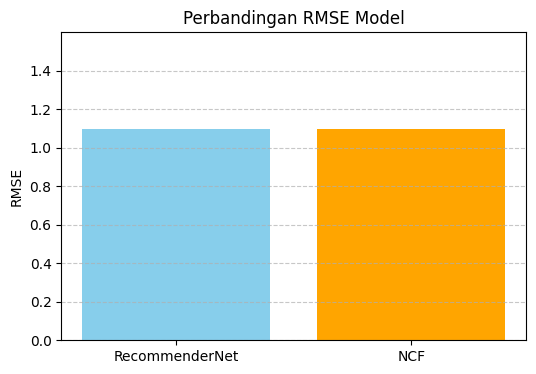

In [27]:
# --- Prediksi ---
y_pred_rec = model_recommendernet.predict(x_val).flatten()
y_pred_ncf = model_ncf.predict(x_val).flatten()

# --- Hitung RMSE ---
rmse_rec = sqrt(mean_squared_error(y_val, y_pred_rec))
rmse_ncf = sqrt(mean_squared_error(y_val, y_pred_ncf))

print(f"RMSE RecommenderNet: {rmse_rec:.4f}")
print(f"RMSE NCF: {rmse_ncf:.4f}")

# --- Visualisasi RMSE ---
plt.figure(figsize=(6, 4))
plt.bar(['RecommenderNet', 'NCF'], [rmse_rec, rmse_ncf], color=['skyblue', 'orange'])
plt.ylabel('RMSE')
plt.title('Perbandingan RMSE Model')
plt.ylim(0, max(rmse_rec, rmse_ncf) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Insight= Berdasarkan hasil evaluasi menggunakan metrik RMSE (Root Mean Squared Error), model RecommenderNet menunjukkan performa yang sedikit lebih baik dibandingkan dengan model NCF . Selisih ini mengindikasikan bahwa prediksi rating dari RecommenderNet lebih mendekati nilai aktual secara rata-rata.

Selanjutnya dilakukan visualisasi hasil Training dan Validation Loss per epoch dari model RecommenderNet dan NCF.

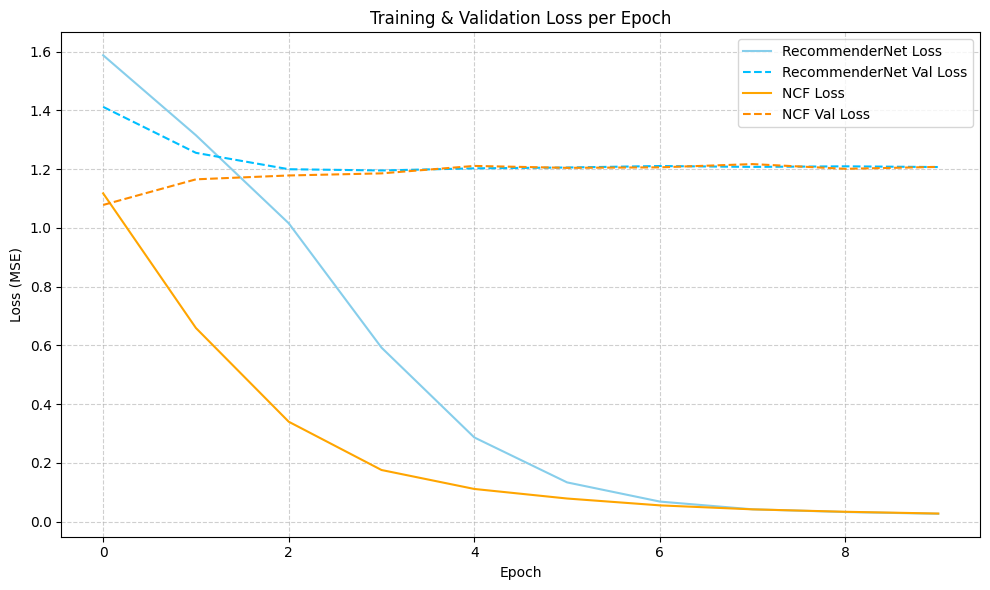

In [28]:
# --- Plot Training & Validation Loss ---
plt.figure(figsize=(10, 6))

# RecommenderNet
plt.plot(history_rnet.history['loss'], label='RecommenderNet Loss', color='skyblue')
plt.plot(history_rnet.history['val_loss'], label='RecommenderNet Val Loss', color='deepskyblue', linestyle='--')

# NCF
plt.plot(history_ncf.history['loss'], label='NCF Loss', color='orange')
plt.plot(history_ncf.history['val_loss'], label='NCF Val Loss', color='darkorange', linestyle='--')

plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Insight= Berdasarkan visualisasi, RecommenderNet memiliki nilai RMSE lebih rendah dibandingkan NCF , grafik validasi menunjukkan bahwa model ini mulai overfit terhadap data pelatihan setelah beberapa epoch. Sebaliknya, NCF menunjukkan performa yang lebih stabil dan konsisten di data validasi.

Selanjutnya saya melakukan evaluasi model menggunakan MSE pada finak training di kedua model.

In [29]:
# RecommenderNet MSE
final_rnet_train_loss = history_rnet.history['loss'][-1]
final_rnet_val_loss = history_rnet.history['val_loss'][-1]

# NCF MSE
final_ncf_train_loss = history_ncf.history['loss'][-1]
final_ncf_val_loss = history_ncf.history['val_loss'][-1]

print(f"RecommenderNet - Final Training MSE: {final_rnet_train_loss:.4f}")
print(f"RecommenderNet - Final Validation MSE: {final_rnet_val_loss:.4f}")
print(f"NCF - Final Training MSE: {final_ncf_train_loss:.4f}")
print(f"NCF - Final Validation MSE: {final_ncf_val_loss:.4f}")


RecommenderNet - Final Training MSE: 0.0268
RecommenderNet - Final Validation MSE: 1.2071
NCF - Final Training MSE: 0.0276
NCF - Final Validation MSE: 1.2077


Ingiht= Berdasarkan hasil evaluasi MSE, hasil kedua model menunjukkan hasil yang cukup mirip dengan hasil Final Validation RecommenderNet di angka 1.2071 sedangkan model NCD memiliki Final Validation di angka 1.2077

Selanjutnya dilakukan perhitungan evaluasi MAE untuk kedua model, untuk memperkuat keputusan untuk memilih salah satu mdodel.

In [30]:
# Menghitung Mean Absolute Error (MAE) untuk model RecommenderNet dan NCF

mae_rec = mean_absolute_error(y_val, y_pred_rec)
mae_ncf = mean_absolute_error(y_val, y_pred_ncf)

print(f"MAE RecommenderNet: {mae_rec:.4f}")
print(f"MAE NCF: {mae_ncf:.4f}")


MAE RecommenderNet: 0.8941
MAE NCF: 0.8610


Insight= Meskipun RecommenderNet unggul pada metrik RMSE, model NCF menunjukkan keunggulan pada metrik MAE, yang mengindikasikan bahwa prediksi NCF secara umum lebih stabil dan lebih konsisten terhadap nilai rating aktual, meskipun mungkin kurang presisi terhadap nilai-nilai ekstrem.

### Evaluasi Hasil Top N recommendation RecommenderNet & NCF

Pada tahap ini saya melakukan percobaan untuk evaluasi top n recommendation, dengan mamsukkan salah satu user. Disini saya menggunakan user 2 sebagai contoh

In [32]:
# Ambil user  dari encoding
example_user_encoded = 2

top_10_recommendations = get_top_n_recommendations(model_recommendernet, example_user_encoded, model_type='recommendernet', top_n=10)

print("Top 10 rekomendasi film untuk user:", top_10_recommendations)

Top 10 rekomendasi film untuk user: ['Sense and Sensibility (1995)'
 'Star Wars: Episode IV - A New Hope (1977)' "Nobody's Fool (1994)"
 'Gone with the Wind (1939)' 'Rain Man (1988)' "Look Who's Talking (1989)"
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)' 'Serenity (2005)'
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'
 'V for Vendetta (2006)']


Insight= berdasarkan top n recommendation menggunakan model RecommenderNet. untuk user 2, didapatkan top 10 rekomendasi film berikut= ['Sense and Sensibility (1995)'
 'Star Wars: Episode IV - A New Hope (1977)' "Nobody's Fool (1994)"
 'Gone with the Wind (1939)' 'Rain Man (1988)' "Look Who's Talking (1989)"
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)' 'Serenity (2005)'
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'
 'V for Vendetta (2006)']

In [33]:
# Ambil user pertama dari encoding
example_user_encoded = 2

top_10_recommendations = get_top_n_recommendations(model_ncf, example_user_encoded, model_type='ncf', top_n=10)

print("Top 10 rekomendasi film untuk user:", top_10_recommendations)


Top 10 rekomendasi film untuk user: ['Apartment, The (1960)' 'Third Man, The (1949)' 'Atlantic City (1980)'
 'Gods and Monsters (1998)' 'Run Lola Run (Lola rennt) (1998)'
 "Guess Who's Coming to Dinner (1967)" 'Brokeback Mountain (2005)'
 'Death Race (2008)' 'Keeper of Lost Causes, The (Kvinden i buret) (2013)'
 'Leviathan (2014)']


Insight= berdasarkan top n recommendation menggunakan model NCF. untuk user 2, didapatkan top 10 rekomendasi film berikut= ['Apartment, The (1960)' 'Third Man, The (1949)' 'Atlantic City (1980)'
 'Gods and Monsters (1998)' 'Run Lola Run (Lola rennt) (1998)'
 "Guess Who's Coming to Dinner (1967)" 'Brokeback Mountain (2005)'
 'Death Race (2008)' 'Keeper of Lost Causes, The (Kvinden i buret) (2013)'
 'Leviathan (2014)']

## Conclusion

 Dalam proyek pengembangan sistem rekomendasi film ini, saya mengimplementasikan dua pendekatan utama, yaitu Content-Based Filtering dan Collaborative Filtering. Pada pendekatan Collaborative Filtering, saya menguji dua arsitektur model deep learning, yakni RecommenderNet dan Neural Collaborative Filtering (NCF).

Hasil evaluasi menunjukkan bahwa kedua model memiliki performa yang cukup kompetitif, dengan nilai RMSE sebesar 1.0964 untuk RecommenderNet dan 1.1055 untuk NCF. Meskipun RecommenderNet sedikit lebih unggul dalam hal RMSE dan MSE, model NCF menunjukkan performa yang lebih stabil dan konsisten, terutama dalam proses pelatihan dan validasi.

Berdasarkan evaluasi tersebut, saya memilih NCF sebagai model akhir yang digunakan dalam sistem rekomendasi ini karena kestabilannya dalam proses pelatihan dan kemampuannya dalam menghasilkan prediksi yang lebih merata, meskipun memiliki RMSE sedikit lebih tinggi dibandingkan RecommenderNet. Selain itu, nilai MAE yang lebih rendah pada NCF menunjukkan bahwa prediksi model ini secara umum lebih mendekati nilai rating sesungguhnya.

Pendekatan content-based digunakan sebagai pelengkap untuk memberikan rekomendasi yang lebih personal terutama ketika data interaksi pengguna masih terbatas (cold start problem).

